Visualizing the Current Electricity Mix of UK from 1990 - 2022


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from matplotlib.ticker import AutoMinorLocator


def Custom_Ax(ax, ylabel_name='', ylabel_size=16, xlabel_name='', xlabel_size=16):
    """
    Customizando Axis Matplotlib.

    Parameters
    ----------
    ax : TYPE
        DESCRIPTION.
    ylabel_name : TYPE, optional
        DESCRIPTION. The default is ''.
    ylabel_size : TYPE, optional
        DESCRIPTION. The default is 16.
    xlabel_name : TYPE, optional
        DESCRIPTION. The default is ''.
    xlabel_size : TYPE, optional
        DESCRIPTION. The default is 16.

        Returns
    -------
    ax : TYPE
        DESCRIPTION.

    """
    ax.set_ylabel(ylabel_name, fontdict={'fontsize': ylabel_size})
    ax.set_xlabel(xlabel_name, fontdict={'fontsize': xlabel_size})
    ax.grid(color='black', linestyle='-', linewidth=1, alpha=.5)
    ax.grid(which='minor', axis="x", color="black", alpha=.2, linewidth=.5, linestyle="--")
    ax.grid(which='minor', axis="y", color="black", alpha=.2, linewidth=.5, linestyle="--")
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.grid(visible=True, which='major', axis="x", color="black", alpha=1, linewidth=.5, linestyle="-")
    ax.grid(visible=True, which='major', axis="y", color="black", alpha=1, linewidth=.5, linestyle="-")

    return ax


file_path = 'owid-energy-data.csv'
df = pd.read_csv(file_path, encoding='gbk')

# 打印列名，检查是否存在与代码中的列名一致的列
print(df.columns)

# 去除列名中的空格
df.columns = df.columns.str.strip()

# 确保 'year' 列是整数类型
df['year'] = df['year'].astype(int)
df['hydro_electricity_%'] = (df['hydro_electricity'] / df['electricity_generation'])
df['nuclear_electricity_%'] = df['nuclear_electricity'] / df['electricity_generation']
df['solar_electricity_%'] = df['solar_electricity'] / df['electricity_generation']
df['wind_electricity_%'] = df['wind_electricity'] / df['electricity_generation']
df['renewables_electricity_%'] = df['renewables_electricity'] / df['electricity_generation']
df['other_renewable_electricity_%'] = df['other_renewable_electricity'] / df['electricity_generation']
df['other_renewable_exc_biofuel_electricity_%'] = df['other_renewable_exc_biofuel_electricity'] / df['electricity_generation']

df['sum_renewable_%'] = df['hydro_electricity_%'] + df['nuclear_electricity_%'] + df['solar_electricity_%'] + df['wind_electricity_%']

Index(['country', 'year', 'iso_code', 'population', 'gdp',
       'biofuel_cons_change_pct', 'biofuel_cons_change_twh',
       'biofuel_cons_per_capita', 'biofuel_consumption',
       'biofuel_elec_per_capita',
       ...
       'solar_share_elec', 'solar_share_energy', 'wind_cons_change_pct',
       'wind_cons_change_twh', 'wind_consumption', 'wind_elec_per_capita',
       'wind_electricity', 'wind_energy_per_capita', 'wind_share_elec',
       'wind_share_energy'],
      dtype='object', length=129)


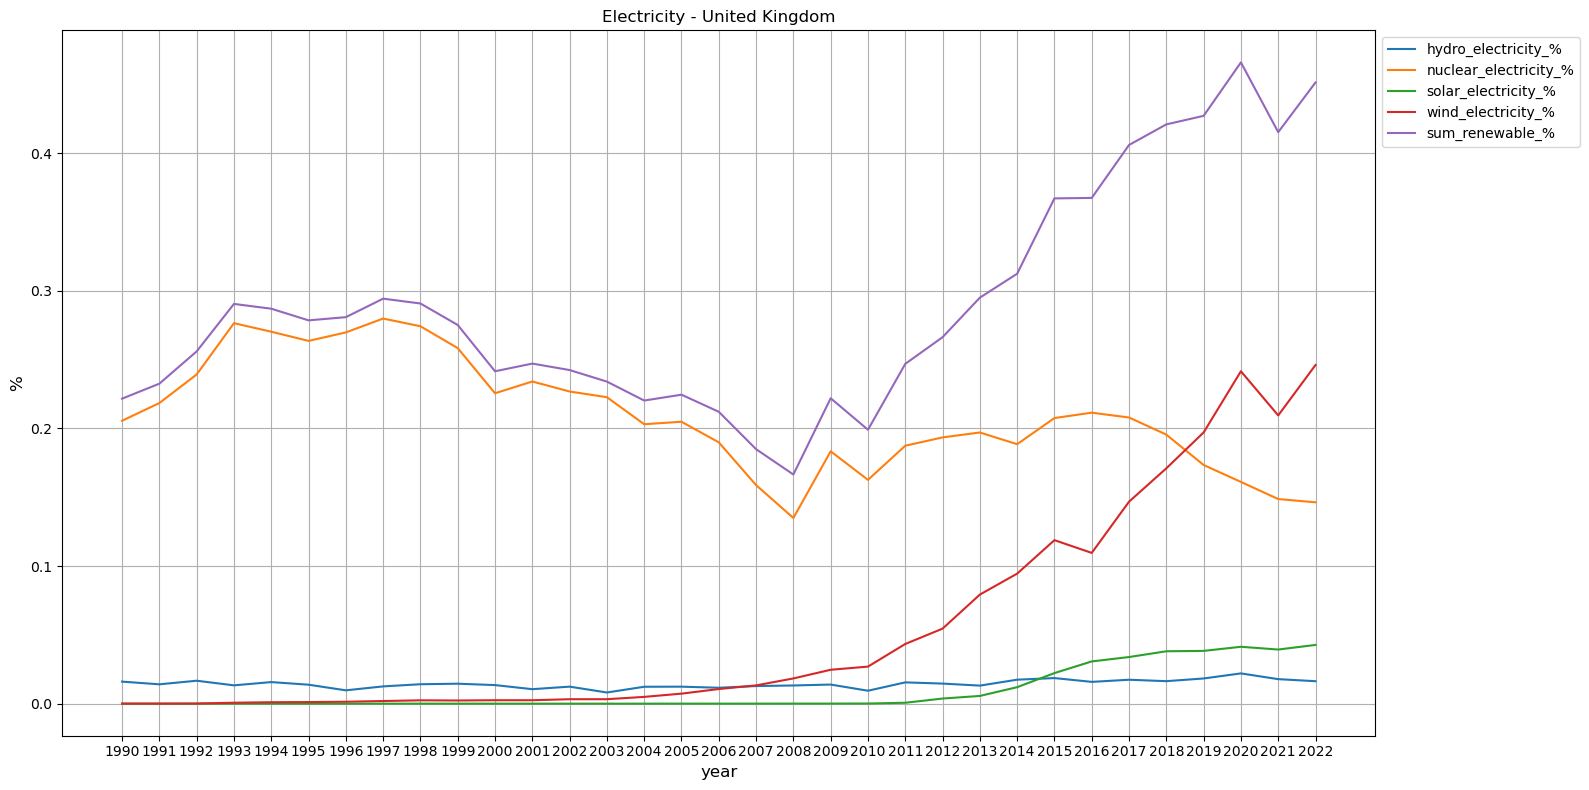

Data saved to 'uk_electricity_1990_2022.csv'


In [5]:
# 检查列名是否正确，如果存在需要修正的列名，修改代码中的列名
fig, ax = plt.subplots(figsize=(16, 8))
ax.set(xticks=df.year[(df['year'] >= 1990) & (df['year'] <= 2022)].unique())

# 设置 x, y 标签的字体大小
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('%', fontsize=12)

df[(df.country == 'United Kingdom') & (df['year'] >= 1990) & (df['year'] <= 2022)].plot(
    kind='line',
    x='year',
    y=['hydro_electricity_%', 'nuclear_electricity_%', 'solar_electricity_%', 'wind_electricity_%', 'sum_renewable_%'],
    ax=ax,
    title='Electricity - United Kingdom',
    grid=True
)

ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()
plt.show()

# 过滤数据：仅保留 'United Kingdom' 且 'year' 在 1990 到 2022 之间的数据
filtered_df = df[(df.country == 'United Kingdom') & (df['year'] >= 1990) & (df['year'] <= 2022)]

# 选择需要保存的列
filtered_df = filtered_df[['year', 'hydro_electricity_%', 'nuclear_electricity_%', 'solar_electricity_%', 'wind_electricity_%', 'sum_renewable_%']]

# 保存到新的 CSV 文件
filtered_df.to_csv('uk_electricity_1990_2022.csv', index=False)

print("Data saved to 'uk_electricity_1990_2022.csv'")

Based on past data, predicting the future electricity mix of UK till 2035.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


def create_dataset(df, time_step=1, feature_column='value'):
    """
    Prepare the dataset for training by creating sequences for LSTM.

    Parameters
    ----------
    df : pandas.DataFrame
        The data containing the time series.
    time_step : int, optional
        The number of previous time steps to use for predicting the next time step.
    feature_column : str, optional
        The column name to predict.

    Returns
    -------
    X : numpy.ndarray
        The input features for training/testing.
    y : numpy.ndarray
        The target labels for training/testing.
    """
    X, y = [], []
    for i in range(len(df) - time_step):
        X.append(df[feature_column].iloc[i:i + time_step].values)
        y.append(df[feature_column].iloc[i + time_step])

    return np.array(X), np.array(y)


def train_test_predict_lstm(df, feature_column='value', time_step=1, test_size=0.1, epochs=50, batch_size=32, forecast_years=13):
    """
    Function to train, test, and predict using an LSTM model.

    Parameters
    ----------
    df : pandas.DataFrame
        The data containing the time series.
    feature_column : str, optional
        The column name to predict. The default is 'value'.
    time_step : int, optional
        The number of previous time steps to use for predicting the next time step.
    test_size : float, optional
        The proportion of the dataset to use as test data. The default is 0.2.
    epochs : int, optional
        Number of epochs for training. The default is 50.
    batch_size : int, optional
        The batch size for training. The default is 32.
    forecast_years : int, optional
        The number of future years to predict. Default is 13.

    Returns
    -------
    model : keras.Model
        The trained LSTM model.
    y_test : numpy.ndarray
        The actual target values for testing.
    y_pred : numpy.ndarray
        The predicted values.
    forecast : numpy.ndarray
        The predicted future values for the specified number of years.
    """


    # Scale the feature data
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_scaled = pd.DataFrame(scaler.fit_transform(df[feature_column].values.reshape(-1, 1)), columns=[feature_column])

    # Prepare the data for LSTM
    X, y = create_dataset(df_scaled, time_step, feature_column)

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    # Reshape X_train and X_test for LSTM input
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Build LSTM Model
    model = Sequential()
    model.add(LSTM(units=64, return_sequences=False, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    # Make predictions on the test set
    y_pred_scaled = model.predict(X_test)

    # Inverse transform to get actual values
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_actual = scaler.inverse_transform(y_pred_scaled)

    # Calculate the performance (e.g., RMSE)
    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    # Forecast the future (next 13 years)
    forecast_input = df_scaled[-time_step:].values.reshape(1, time_step, 1)
    forecast = []

    for _ in range(forecast_years):
        next_pred_scaled = model.predict(forecast_input)
        forecast.append(next_pred_scaled[0, 0])
        forecast_input = np.append(forecast_input[:, 1:, :], next_pred_scaled.reshape(1, 1, 1), axis=1)

    # Inverse transform forecasted values
    forecast_actual = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

    return model, y_test_actual, y_pred_actual, forecast_actual


# Load the data
file_path = 'uk_electricity_1990_2022.csv'
df = pd.read_csv(file_path, encoding='gbk')

# Specify the features to predict
features = ['hydro_electricity_%', 'nuclear_electricity_%', 'solar_electricity_%', 'wind_electricity_%']

# Train, test, and predict for each feature
forecast_results = {}
for feature in features:
    model, y_test, y_pred, forecast = train_test_predict_lstm(df, feature_column=feature, time_step=5, epochs=100, batch_size=8, forecast_years=13)
    forecast_results[feature] = forecast

Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2080 
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 0.1855
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 0.0979
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - loss: 0.0861
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - loss: 0.0544
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - loss: 0.0375
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - loss: 0.0253
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0377
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 0.0312
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - loss: 0.0262
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - loss: 0.0274
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - loss: 0.0346
Epoch 13/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 0.0333
Epoch 14/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - loss: 0.0216
Epoch 15/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - loss: 0.0283
Epoch 16/100
4/4 ━━

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 0.4274
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - loss: 0.2733
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - loss: 0.2145
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - loss: 0.1024
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - loss: 0.0731
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - loss: 0.0371
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step - loss: 0.0394
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - loss: 0.0404
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - loss: 0.0570
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - loss: 0.0474
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - loss: 0.0313
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - loss: 0.0392
Epoch 13/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step - loss: 0.0378
Epoch 14/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - loss: 0.0311
Epoch 15/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 0.0319
Epoch 16/100
4/4

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1141  
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - loss: 0.0792
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - loss: 0.0602
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0730
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - loss: 0.0806
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step - loss: 0.0498
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - loss: 0.0609
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - loss: 0.0464
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step - loss: 0.0477
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step - loss: 0.0392
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - loss: 0.0360
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 0.0322
Epoch 13/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 0.0287
Epoch 14/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 0.0267
Epoch 15/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - loss: 0.0227
Epoch 16/100
4/4

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 0.0848
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - loss: 0.0577
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - loss: 0.0408
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - loss: 0.0337
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - loss: 0.0394
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - loss: 0.0214
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - loss: 0.0241
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - loss: 0.0200
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - loss: 0.0174
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - loss: 0.0155
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - loss: 0.0118
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - loss: 0.0099
Epoch 13/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - loss: 0.0074
Epoch 14/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - loss: 0.0057
Epoch 15/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - loss: 0.0050
Epoch 16/100
4/4

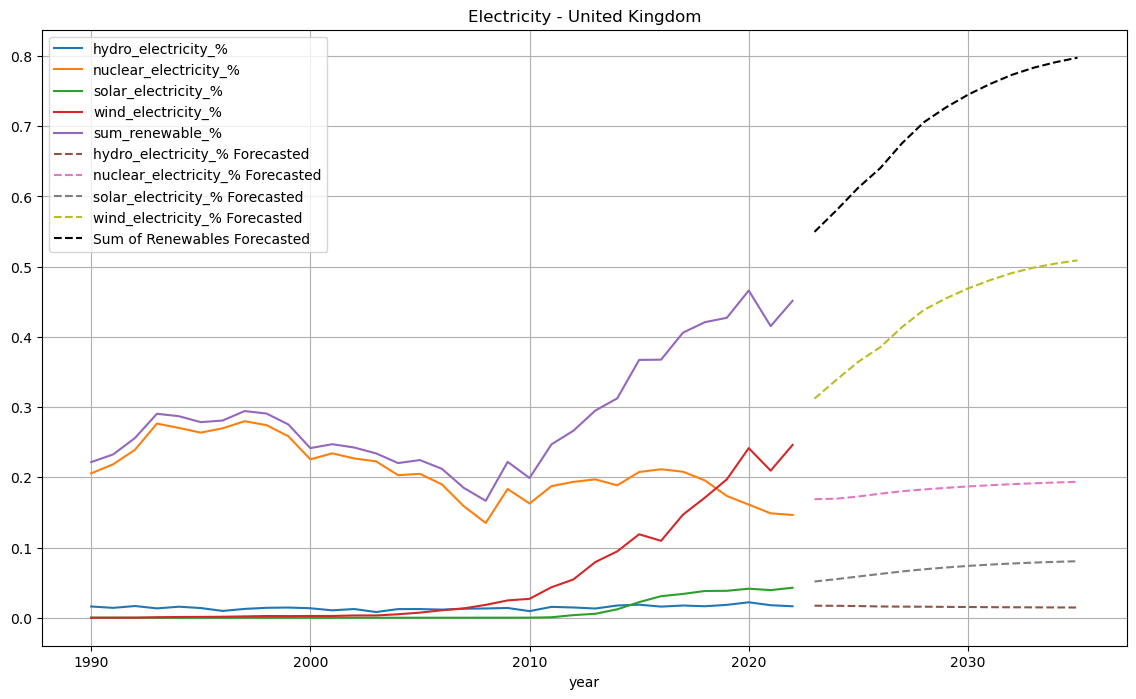

In [8]:
# 计算每年各个能源的总和
df['sum_renewable_%'] = df['hydro_electricity_%'] + df['nuclear_electricity_%'] + df['solar_electricity_%'] + df['wind_electricity_%']

# 同样，计算预测数据的总和
forecast_results['sum_renewable_%'] = forecast_results['hydro_electricity_%'] + forecast_results['nuclear_electricity_%'] + forecast_results['solar_electricity_%'] + forecast_results['wind_electricity_%']

# Plot actual and forecasted values
plt.figure(figsize=(14, 8))
ax = plt.gca()

# Plot the actual data for each feature
df[(df['year'] >= 1990) & (df['year'] <= 2022)].plot(
    kind='line',
    x='year',
    y=features + ['sum_renewable_%'],  # Add sum_renewable_% to the features
    ax=ax,
    title='Electricity - United Kingdom',
    grid=True
)

# Plot the forecasted data for each feature and sum
years = np.arange(df['year'].iloc[-1] + 1, df['year'].iloc[-1] + 1 + 13)
for feature in features:
    ax.plot(years, forecast_results[feature], label=f'{feature} Forecasted', linestyle='--')

# Plot the forecasted sum of renewables
ax.plot(years, forecast_results['sum_renewable_%'], label='Sum of Renewables Forecasted', linestyle='--', color='black')

# Add legends and grid
plt.legend()
plt.grid(True)
plt.show()